# Inferência Causal e Falas Presidenciais 

# Introdução

A análise causal é um tópico quente no mundo da ciência de dados. Com essa ferramenta somos capazes de entender dinâmicas de causa e efeito de variáveis que são do nosso interesse. Por exemplo: 
* Qual o impacto de uma campanha de marketing nas minhas vendas
* Qual o impacto do aumento da taxa de juros na contratação de financimento imobiliário
* Qual o impacto da entrada de um novo concorrente na retenção dos meus clientes

O objetivo aqui é trazer uma aplicação real de análise causal e apresentar como esse tipo de problema é solucionado bem como a interpretação que fazemos dos dados. O estudo que abordaremos usará este ferramental para entender como duas ações do ex presidente Jair Bolsonaro impactaram no distânciamento social no começo da pandemia COVID-19. 

Esse artigo é uma réplica dos resultados do paper "More than Words: Leaders’ Speech and Risky Behavior During a Pandemic" de Nicolás Ajzenman, Tiago Cavalcanti e Daniel Da Mata publicado na American Economics Review. Aqui, quero enfatizar os métodos de análise para o público que está iniciando os estudos em inferência causal.

# Contexto

Durante o ano de 2020, a Organização Mundial da Saúde defendeu a política de distânciamento social para reduzir a disseminação do vírus COVID-19 ao redor do mundo. Mas no Brasil viveu-se um cabo de guerra. De um lado, estados e municípios se esforçaram para implantar o distânciamento social e, do outro lado, o presidente da época, Jair Bolsonaro, desincentivou tais medidas por meio de falas que foram amplamente divulgadas nas redes sociais e na mídia tradicional. 

No meses iniciais da pandemia, os nossos conhecimentos sobre a doença eram escassos e não tínhamos dimensão do potencial destrutivo que a COVID 19 causaria no mundo. Foi justamente nesse período que os autores do estudo identificaram duas ações com grande repercursão do ex presidente Jair Bolsonaro:

    1) 15 de Março de 2020: uma aparição pública no meio de um protesto contra o Congresso e a Suprema Corte organizado por conservadores ativistas alinhados ao presidente. Nesse momento, o presidente tirou selfies e cumprimentou diveros apoiadores - descumprindo medidas de isolamento.
    
    2) 24 de Março de 2020: um pronunciamento presidencial transimitida nos canais abertos de TV e rádio. Bolsonaro enfaticamente se opôs às políticas de distanciamento social praticadas por estados e município, enfatizou que o país precisava voltar a normalidade e minimizou os efeitos da pandemia.

Por mais que Bolsonaro não tenha implementado nenhuma medida oficial para restringir as políticas de distanciamento social, mostrou-se que apenas o seu exemplo seria suficiente para arrefecer o isolamento da população. 

Replicaremos algo muito próximo da metodologia original do estudo. Para tanto, faremos uso de um modelo de Diferenças em Diferenças Dinâmico para entender o efeito dessas ações no comportamento da população.

In [3]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from linearmodels.iv.absorbing import AbsorbingLS, Interaction

In [4]:
path = r'171661-V1\Data'

In [5]:
df_dist = pd.read_stata(path+r'\social_distancing.dta')
df_eleicao = pd.read_stata(path+r'\election2018.dta')
df_pop2019 = pd.read_stata(path+r'\pop_2019.dta')
df_munic = pd.read_stata(path+r'\munic_raio_2018.dta')
df_pop = pd.read_stata(path+r'\population_dataset.dta')

# Fixar datas
df_dist = df_dist[df_dist.date.between('2020-02-01', '2020-04-14')]

# Retira municipios sem info
df_dist = df_dist[df_dist.id_mun6.isin((df_dist.groupby('id_mun6').apply(lambda x: x.indice_isolamento.isnull().mean())).loc[lambda y: y==0].index)]
df_dist = df_dist[df_dist.name_state!='Distrito Federal']

df_mod = df_dist.merge(df_eleicao).merge(df_pop).merge(df_pop2019)

# Converter em categoria
df_mod.id_municipality = df_mod.id_municipality.astype(int).astype('category')
df_mod.id_state = df_mod.id_state.astype('category')
df_mod.date = df_mod.date.astype('category')

# Índice de Distanciamento Social

Para acompanhar o distanciamento social, usaremos o índice desenvolvido pela empresa In Loco a partir do rastreamento de celulares. O indicador mostra, diariamente, o percetual de aparelhos de um munícipio que permanece a uma distância máxima de 450 metros da casa do seu dono. O nosso estudo se retringirá aos dias 1° de fevereiro de 2020 à 14 de abril de 2020 (74 dias).

In [19]:
df_mod.head()

,date,id_municipality,id_mun6,id_state,name_state,indice_isolamento,frvoto_bolso_1turno,pmpob,pesorur,pesotot,pop_2019
0,2020-02-01,1100015,110001,11,Rondônia,0.286713,0.6002,26.04,10422.0,24392.0,22945
1,2020-02-02,1100015,110001,11,Rondônia,0.353896,0.6002,26.04,10422.0,24392.0,22945
2,2020-02-03,1100015,110001,11,Rondônia,0.177083,0.6002,26.04,10422.0,24392.0,22945
3,2020-02-04,1100015,110001,11,Rondônia,0.240418,0.6002,26.04,10422.0,24392.0,22945
4,2020-02-05,1100015,110001,11,Rondônia,0.168539,0.6002,26.04,10422.0,24392.0,22945


Ao olhar a mediana do indice de isolamento por localidade, percebemos que o indicador permanece baixo antes do "estouro" da pandemia e, durante a segunda metado do mês de março, houve um esforço para reduzir aglomerações. É justo nesse período as aparições do presidente, as quais serão destacadas com linhas tracejadas pretas.

Já em 1° de Abril, percebemos que a maioria dos municípios tinham pelo menos metade da população em casa. Mas será que todos os municípios tiveram um aumento homogêneo no isolamento? 

Quando olhamos o desvio padrão dia a dia, percebemos que o índice de isolamento teve uma dispersão maior entre os municípios depois da segunda metade de março. O que queremos testar é se as ações do presidente estão relacionadas com o aumento da dispersão.

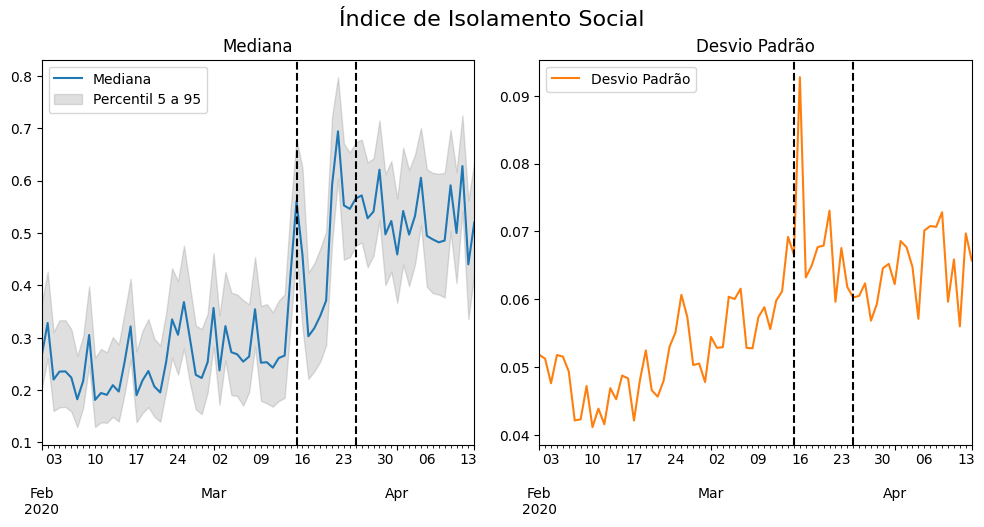

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

fig.suptitle('Índice de Isolamento Social', fontsize=16)

ax[0].set_title('Mediana')

dist_median = df_dist.dropna().groupby('date').indice_isolamento.median()
dist_95 = df_dist.dropna().groupby('date').indice_isolamento.quantile(.95)
dist_05 = df_dist.dropna().groupby('date').indice_isolamento.quantile(.05)

dist_median.plot(ax=ax[0], label='Mediana')
ax[0].axvline(x = '15-03-2020', color = 'black', ls='--')
ax[0].axvline(x = '25-03-2020', color = 'black', ls='--')
ax[0].fill_between(dist_95.index, dist_05, dist_95, alpha=0.25, color='grey', label='Percentil 5 a 95')
ax[0].set_xlabel('')
ax[0].legend()

ax[1].set_title('Desvio Padrão')

df_dist.dropna().groupby('date').indice_isolamento.std().plot(ax=ax[1], label='Desvio Padrão', color='C1')

ax[1].axvline(x = '15-03-2020', color = 'black', ls='--')
ax[1].axvline(x = '25-03-2020', color = 'black', ls='--')
ax[1].set_xlabel('')
ax[1].legend()

plt.subplots_adjust(wspace=0.15)

# Suposição

Vamos assumir que o presidente fala apenas para os seus apoiadores. Logo, um individuo só irá reduzir sua propensão a ficar em casa após as manifestações do presidente se ele for um apoiador do Bolsonaro, caso o contrário, não surgirá efeito.

Como estamos trabalhando com dados municipais, vamos usar o resultado das eleições de 2018 como proxy para identificar o quanto um município apoia o presidente. Em outras palavras, vamos assumir que o efeito das ações do chefe do executivo afetam igualmente municípios que tiveram o mesmo resultado nas eleições. Além disso, se ninguém votou no Bolsonaro no município em 2018 então o efeito é nulo.

# Modelo 1: Modelo de Diferenças em Diferenças Dinâmico Simples

Feita a principal suposição, podemos construir o nosso primeiro modelo.

Vamos assumir que, além do impacto das ações do bolsonaro depender do resultado da eleição no município, ele também tem um valor diferente para cada momento do tempo - pois queremos entender justamente se depois do dia 15 e 24 de março o impacto muda. Na prática, precisamos que o nosso modelo incorpore para cada dia da nossa base, qual o impacto no distanciamento social que as falas do presidente têm em seus apoiadores.

Conseguiremos tal resultado com o seguinte modelo de regressão:

$$Y_{m,d} = \alpha + \sum_{t}{\gamma_t*1(t=d)} + \sum_{t}{\beta_t[{GovSup_m}*1(t=d)]} + \epsilon_{m,d}$$

Onde $Y_{m,d}$ é o índice de isolamento social do município $m$ no dia $d$ e $GovSup_m$ é o percentual de votos que o Bolsonaro teve nas eleições de 2018 no município $m$.

No modelo, a função indicadora $1(t=d)$ cria dummies diárias para cada dia $d$, que assume o valor $1$ caso $t=d$ e $0$ caso o contrário. O dia base dessas dummies é o dia anterior a primeira aparição do Bolsonaro. Portanto, não temos uma dummy para o dia 14 de março.

$\alpha$, $\gamma_d$ e $\beta_d$ são os parâmetros a serem estimados via OLS ponderado pelo tamanho da população de cada município.

Note como o modelo é esparso. Vamos usar a função AbsorbingLS do pacote linearmodel - que é otimizado para esse tipo de problema. 

Agora vamos interpretar o que esse modelo significa. Dado um dia $d$, um município $m$, temos que o índice de isolamento social será predito pelo modelo como sendo igual a $\alpha + \gamma_d + \beta_d*GovSup_m$. Isso implica que:

* Para cada ponto percentual a mais de votos conquistado pelo presidente no município, o índice de isolamento social no dia $d$ é acrescido em $\beta_d$ pontos percentuais.
* Para qualquer município, o modelo diz que o índice de isolamento social será de $\alpha$ no dia 14 de março, dado que este é o nosso dia base. Para o dia seguinte, ou seja $D=$15 de março, temos que o índice será acrescido de um fator que não depende do apoio ao presidente (no caso $\gamma_{D}$) e de outro fator ($\beta_{D}*GovSup_m$) que depende. Portanto, o parâmetro $\beta_{D}$ refletirá o impacto das ações no dia seguinte. De forma análoga, para $D'=$ 16 de março, $\beta_{D'}$ refletirá o impacto dois dias depois.

Dadas as características do modelo, a literatura chama essa abordagem de diferenças em diferenças dinâmico (dynamic difference-in-difference). Pois estamos estimando o acréscimo ao longo do tempo do isolamento social de um grupo controle (bolsonaristas antes das ações do presidente) contra um grupo tratamento (bolsonaristas após ações do presidente).

Para analisar os resultados, vamos pegar o coeficiente que nos diz o acréscimo no isolamento e plotar na linha do tempo. 

Vemos que um dia após a primeira apariação do presidente, o impacto no distanciamento social foi forte. Para cada um ponto percentual a mais que o Bolsonato teve no município, o indice de isolamento social diminuiu 0.2 pontos percentuais em relação ao que era em 14 de março. Mas o efeito é parcialmente dissipado ao longo dos próximos dias.

In [14]:
# Criando as nossas variáveis de interesse
dummies_date = pd.get_dummies(df_mod.date.dt.strftime('%Y%m%d'), prefix='date', dtype=np.int8, sparse=True)
dummies_date = dummies_date.drop(['date_20200314'], axis=1) # Retirar dummy do dia 14 de março

effect_target = dummies_date.mul(df_mod.frvoto_bolso_1turno, axis=0)
effect_target.columns = [i.replace('date_', 'target_') for i in effect_target.columns]

In [15]:
mod_1 = AbsorbingLS(
    dependent=df_mod.indice_isolamento, 
    exog=effect_target, 
    absorb=df_mod[['date']], # Criar dummies para cada dia
    weights=df_mod.pop_2019, # Peso de cada observação
    drop_absorbed=True).fit()

In [16]:
df_params_1 = mod_1.params

df_params_1 = df_params_1[effect_target.columns]
df_params_1['target_20200314'] = 0
df_params_1 = df_params_1.sort_index()

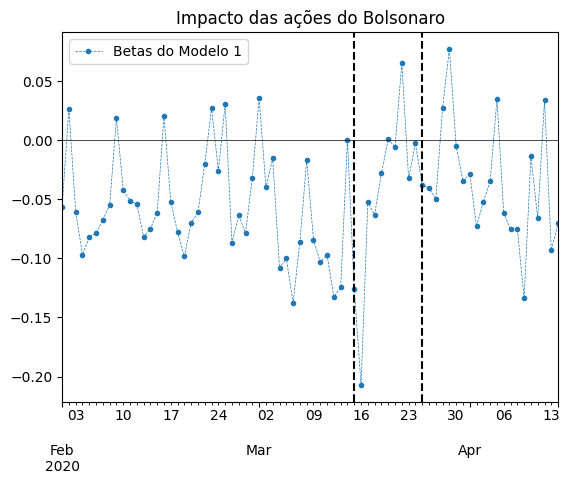

In [17]:
fig, ax = plt.subplots()
ax.set_title('Impacto das ações do Bolsonaro')

pd.Series(df_params_1.values, 
          name='Betas do Modelo 1', 
          index=df_mod.date.astype('datetime64[ns]').sort_values().unique()
         ).plot(ls='--', style='o', lw=.5, ms=3, ax=ax)

ax.axvline(x = '15-03-2020', color = 'black', ls='--')
ax.axvline(x = '25-03-2020', color = 'black', ls='--')
ax.axhline(y = 0, color = 'black', ls='-', lw=.5)
ax.set_xlabel('')
ax.legend()

# Modelo 2: Inclusão dos confounder 

O modelo anterior é apenas uma primeira tentativa de estimar o efeito das ações do Bolsonaro. Podemos melhorar ainda mais. 

Um das ferramentas que a Inferência Causal possui é o controle dos cofounders. Quando temos uma variável que possui relação causal tanto com o índice de isolamento e com o resultado das eleições no município, temos que levá-la em conta no nosso modelo. Chamamos essa variável de cofounder.

Por exemplo, suponha que um município tem uma alta taxa de pobreza. Sabemos que os mais pobres tendem a não votar para o Bolsonaro e, pode-se argumentar, que é mais difícil ficar em casa quando se tem um emprego instável e nenhuma reserva de emergência - situação comum nas regiões mais pobres do país. Quando olhamos a dinâmica de isolamento social de um local mais carente, vemos que dia após dia é o índice de isolamento social cai, não por causa das falas do presidente, mas pelas dificuldades que a população dessa cidade passa.

Os autores do paper sugerem que é importante controlar por confounders invariantes no tempo que são sabidamente muito correlacionados com o apoio ao Bolsonaro e com o isolamento social: ruaralidade e pobreza. Além disso, vamos permitir uma interação dessas variáveis com as dummies de dia. 

Segundo os autores, dessa forma, aliviaremos uma preocupação que pode ser levantada de que as mensagens do Bolsonaro afetam o distanciamento de forma diferente em munícipios pró-Bolsoaro não por causa do seu alinhamento político, mas por causa de outras características invariantes no tempo, que estão correlacionadas com as preferências políticas da população.

Além disso, como muitas políticas de distanciamento social foram implementadas a nível estadual e ao longo dos dias, vamos incluir também dummies de unidade da federação interagidas com as dummies de período. Novamente, os autores defendem que algumas políticas podem ter sido implementas como uma reação ao discurso do Bolsonaro, dessa forma, se não levarmos em conta esse efeito, produziremos efeitos incorretos.

Por último, uma vantagem de termos informações de isolamento social de cada cidade para cada dia, é que podemos explorar o que chamamos de Efeito Fixo do município - em outras palavras, vamos incoporar uma variável dummy para cada município do nosso banco de dados. Dessa maneira, todas as características que são invariantes no tempo e que podem afetar tanto o isolamento social quanto o apoio do Bolsonaro serão incorporadas no modelo. Nesse último caso, não há como ter interação com as dummies temporais.

Ao analisar os resultados, vemos que o impacto antes dos discursos do presidente são próximos de 0. Ao decorrer dos dias após a primeira aparição do chefe do executivo, vemos que o impacto vai se tornando cada vez mais negativo.

In [20]:
# Dummies Pobreza
# Não é pobre se a taxa de pobreza é acima da mediana nacional
df_mod['not_poor'] = (df_mod['pmpob']>16.9).astype(float) 

# Dummies Ruralidades
# É rual se a proporção de moradores vivendo em áreas urbanas é abaixo da mediana
df_mod['rural'] = (df_mod['pesorur']/df_mod['pesotot']>.2768515).astype(float)

# Dummies UF
dummies_uf = pd.get_dummies(df_mod['id_state'], drop_first=True, sparse=True, prefix='state', dtype=np.int8)

df_mod = pd.concat([df_mod,  dummies_uf], axis=1)

In [21]:
# Garantir a interação das variáveis de probreza, ruralidade e estado com as dummies de data
ite = Interaction(cat=df_mod[['date']], cont=df_mod[
                  ['not_poor', 'rural', 'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
                   'state_21', 'state_22', 'state_23', 'state_24', 'state_25', 'state_26',
                   'state_27', 'state_28', 'state_29', 'state_31', 'state_32', 'state_33',
                   'state_35', 'state_41', 'state_42', 'state_43', 'state_50', 'state_51',
                   'state_52']])

In [22]:
df_mod['date_state'] = df_mod.id_state.astype(str)+'_'+df_mod.date.astype('datetime64[ns]').dt.strftime('%Y%m%d').astype(str)

In [23]:
mod_2 = AbsorbingLS(
    dependent=df_mod.indice_isolamento, 
    exog=sm.add_constant(effect_target), 
    absorb=df_mod[['date', 'id_municipality']], 
    interactions=ite,
    weights=df_mod.pop_2019, 
    drop_absorbed=True).fit(cov_type='clustered', clusters=df_mod['date_state'])

In [24]:
df_params_2 = mod_2.params.copy()
df_params_2 = df_params_2.drop(['const'])
df_params_2['target_20200314'] = 0
df_params_2 = df_params_2.sort_index()

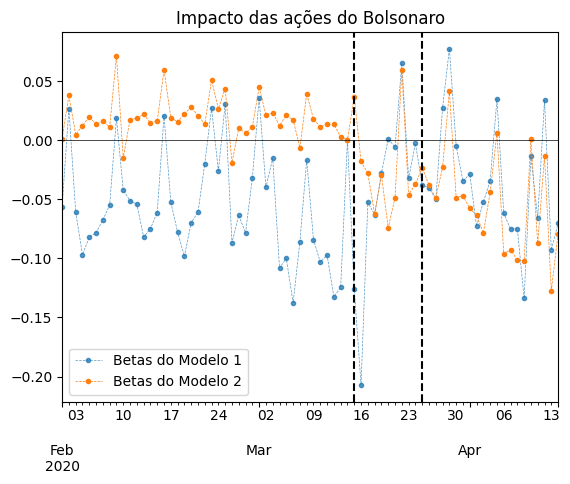

In [25]:
fig, ax = plt.subplots()
ax.set_title('Impacto das ações do Bolsonaro')

pd.Series(df_params_1.values, name='Betas do Modelo 1', index=df_mod.date.astype('datetime64[ns]').sort_values().unique()
         ).plot(ls='--', style='o', lw=.5, ms=3, ax=ax, alpha=.75)

pd.Series(df_params_2.values, name='Betas do Modelo 2', index=df_mod.date.astype('datetime64[ns]').sort_values().unique()
         ).plot(ls='--', style='o', lw=.5, ms=3, ax=ax)


ax.axvline(x = '15-03-2020', color = 'black', ls='--')
ax.axvline(x = '25-03-2020', color = 'black', ls='--')
ax.axhline(y = 0, color = 'black', ls='-', lw=.5)
ax.set_xlabel('')
ax.legend()

# Bônus: efeito estatisticamente diferente de 0

Para dar ainda mais robustez ao impacto estimado, os autores do paper estimaram um intervalo de confianças clusterizado. Ao replicar a metodologia, percebemos que os efeitos computados para antes do dia 15 de março são estatisticamente iguais a 0. Sendo que após o dia 15 encontramos vários dias estatisticamente negativos e diferentes de 0.

In [26]:
conf_int = mod_2.conf_int().copy().sort_index()
conf_int.loc['target_20200314', 'lower'] = 0
conf_int.loc['target_20200314', 'upper'] = 0
conf_int = conf_int.sort_index()
conf_int = conf_int.drop(['const'])

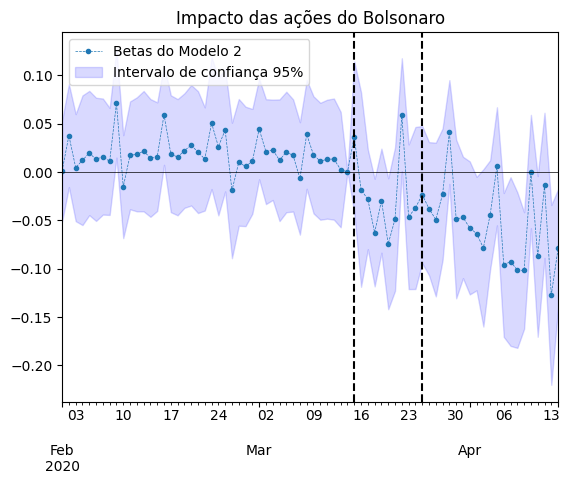

In [27]:
fig, ax = plt.subplots()
ax.set_title('Impacto das ações do Bolsonaro')

pd.Series(df_params_2.values, name='Betas do Modelo 2', index=df_mod.date.astype('datetime64[ns]').sort_values().unique()
         ).plot(ls='--', style='o', lw=.5, ms=3, ax=ax)

dist_95 = pd.Series(conf_int['upper'].values, index=df_mod.date.astype('datetime64[ns]').sort_values().unique())
dist_05 =  pd.Series(conf_int['lower'].values, index=df_mod.date.astype('datetime64[ns]').sort_values().unique())

ax.fill_between(dist_95.index, dist_05, dist_95, alpha=0.15, color='blue', label='Intervalo de confiança 95%')

ax.axvline(x = '15-03-2020', color = 'black', ls='--')
ax.axvline(x = '25-03-2020', color = 'black', ls='--')
ax.axhline(y = 0, color = 'black', ls='-', lw=.5)
ax.set_xlabel('')
ax.legend()

# Conclusão

Com esta última especificação, podemos notar que até o dia 14 de março, o fato do município apoiar o presidente não impactava no distanciamento social, inclusive os autores do paper estimam um intervalo de confiança para esses parâmetros e concluem que são estatiscamente iguais a zero. Entretando, a partir das aparições públicas do Bolsonaro, notamos que há um impacto negativo, crescente ao longo do tempo e estatiscamente diferente de 0 no distanciamento social.